In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import time
import copy

%matplotlib inline

In [2]:
data_transforms = {  
    'train' : transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])                    

  ]),

 'val' : transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
  ])
}

In [3]:
data_dir = '/content/drive/My Drive/vision/torch/data/hymenoptera_data'
image_datasets = { x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in  ['train','val']}

In [4]:
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train','val']}
dataset_sizes = { x : len(image_datasets[x]) for x in ['train','val']}

In [5]:
class_names = image_datasets['train'].classes

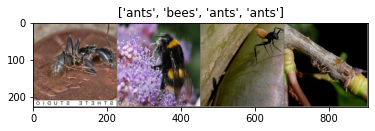

In [6]:
def imageshow(img, title=None):
  img = img.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])

  img = std * img + mean
  img = np.clip(img, 0,1)
  plt.imshow(img)

  if title is not None:
    plt.title(title)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imageshow(out,title = [class_names[x] for x in classes])

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
models_ft = models.resnet18(pretrained=True)
num_ftrs = models_ft.fc.in_features
models_ft = models_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(models_ft.parameters(),lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {} / {}'.format(epoch, num_epochs-1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss =0.0
      running_corrects = 0

      for inputs, lables in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = inputs.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs,labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds==labels.data)

      if phase =='train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss : {:.4f} ACC : {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase =='val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model_state_dict())
    print()

  time_elapsed = time.time() - since
  print('Training complete in  {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  model.load_state_dict(best_model_wts)
  return model

In [10]:
def cisualize_model(model, num_images=6):
  was_training = model.was_training
  model.eval()
  images_so_far = 0
  with torch.no_grad():
    for i, (inputs,labels) in eumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = inputs.to(device)

      outputs = model(inputs)
      _,preds = torch.max(outputs,1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted : {}'.format(class_names[preds[j]]))
        imshow(inputs.cput.data[j])

        if images_so_far == num_images:
                      model.train(mode=was_training)
                      return
      model.train(mode=was_training)

In [11]:
models_ft = train_model(models_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0 / 24
----------


RuntimeError: ignored